# Data Compression using DCT and DFT

**Author**: Brandon Liston

**Last Updated Date**: 01/05/2026

**Description**:  
This notebook is purposed to walkthrough both the implementation of the Discrete  
Cosine Transform (DCT) and Discrete Fourier Transform (DFT) and empirically  
evaluate their effectiveness in 2D compression. Optimization of implementations  
is not a focus for this notebook, only theory and implementation without use of  
existing 3rd party modules.

**References**:  
https://en.wikipedia.org/wiki/Discrete_cosine_transform  
https://en.wikipedia.org/wiki/Discrete_Fourier_transform  
https://www.mathworks.com/help/images/ref/dct2.html  
https://www.mathworks.com/help/matlab/ref/fft2.html  
https://engineering.purdue.edu/~bouman/grad-labs/JPEG-Image-Coding/pdf/lab.pdf  
https://ekrem-7-fidan.medium.com/dct-and-dft-for-1d-and-2d-signals-discrete-cosine-transform-and-discrete-fourier-transform-59feb837441d  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1D Transform Functions

Below we'll first define and implement 1D formulations of the DCT and DFT.

The major extension the Discrete Fourier transform adds to the completely  
real-valued Discrete Cosine Transform is an imaginary sinusoidal component,  
allowing for phase information of the input signal to be captured in the  
transformed signal.

The complex `sin` extension in the DFT is an orthogonal function to the `cos`  
correlation base in the interval $[0, 2\pi]$.

$$
\text{Orthogonal Functions } \int f(x)g(x) dx = 0
$$

$$
\int_{0}^{2 \pi} cos(x) sin(x) dx = 0
$$

Discretely, the $Dot Product$ of the 2 functions will always sum to $0$ in the  
interval $[0, 2\pi]$. This additionally holds for any complete periods of either  
function.

$$
\int_{0}^{2 \pi} cos(nx) sin(mx) dx = 0 \text{ , where } n, m \in \mathbf{Z}
$$

Below illustrates this property discretely over the interval $[0, 2\pi]$.

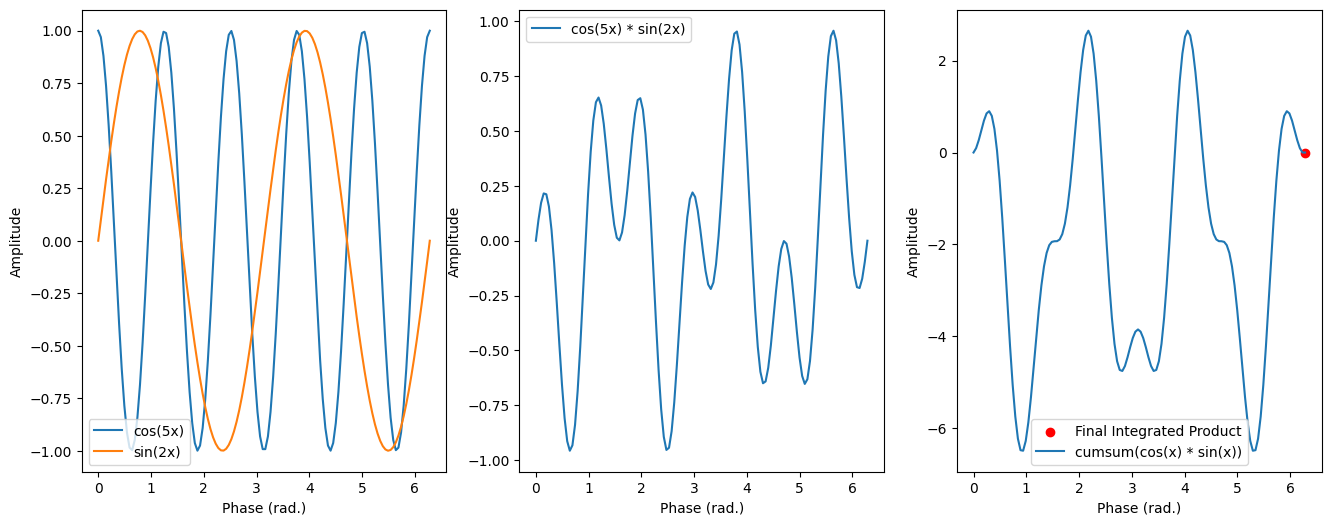

In [2]:
N: int = 128
n: int = 5
m: int = 2
phi = np.linspace(0.0, 2 * np.pi, N)

cos_signal = np.cos(phi * n)
sin_signal = np.sin(phi * m)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(16.0, 6.0)

axes[0].plot(phi, cos_signal, label=f"cos({n}x)")
axes[0].plot(phi, sin_signal, label=f"sin({m}x)")
axes[0].legend()
axes[0].set_xlabel("Phase (rad.)")
axes[0].set_ylabel("Amplitude")

cos_sin_product = cos_signal * sin_signal
axes[1].plot(phi, cos_sin_product, label=f"cos({n}x) * sin({m}x)")
axes[1].legend()
axes[1].set_xlabel("Phase (rad.)")
axes[1].set_ylabel("Amplitude")

cos_sin_product_cum_sum = np.cumsum(cos_sin_product)
axes[2].scatter(
    [phi[-1]], 
    [cos_sin_product_cum_sum[-1]], 
    color="red",
    label="Final Integrated Product"
)
axes[2].plot(phi, cos_sin_product_cum_sum, label="cumsum(cos(x) * sin(x))")
axes[2].legend()
axes[2].set_xlabel("Phase (rad.)")
_ = axes[2].set_ylabel("Amplitude")

Next we'll naively implemented both DCT and FT transforms and visualize their  
computed coefficients against the same input signal.

### 1D Discrete Cosine Transform (DCT)

$$
X[k] = \sqrt{\frac{2}{N}} \text{ } \sum_{n=0}^{N-1}{x[n] \cdot cos(\frac{\pi}{N}(n + \frac{1}{2})k)}, ... k = 0, 1, 2, ..., N - 1
$$

### 1D Discrete Fourier Transform (DFT)

$$
X[k] = \sum_{n=0}^{N-1}{x[n] \cdot cos(2 \pi \frac{k}{N} n) + j sin(2 \pi \frac{k}{N} n)}, ... k = 0, 1, 2, ..., N - 1
$$

$$
= \sum_{n=0}^{N-1}{x[n] \cdot \exp^{-j 2 \pi \frac{k}{N} n }}, ... k = 0, 1, 2, ..., N - 1
$$

*note*, the DCT uses half period basis functions, while the FT uses full periods.

In [3]:
def dct_freq_component_signal(k: int, N: int) -> np.ndarray:
    n = np.arange(N)
    return np.cos((np.pi / N) * (n + 0.5) * k)


def simple_1d_dct(x: np.ndarray) -> np.ndarray:
    N = len(x)
    X = np.zeros_like(x)
    for ki, k in enumerate(np.arange(N)):
        X[ki] = np.sqrt(2 / N) * np.sum(x * dct_freq_component_signal(k, N))
    return X

In [4]:
def dft_freq_component_signal(k: int, N: int) -> np.ndarray:
    n = np.arange(N)
    return np.exp(-1j * 2 * np.pi * k * n / N)


def simple_1d_dft(x: np.ndarray) -> np.ndarray:
    N = len(x)
    X = np.zeros_like(x)
    X = X.astype(np.complex128)
    x_comp = x.astype(np.complex128)
    for ki, k in enumerate(np.arange(N)):
        X[ki] = np.sum(x_comp * dft_freq_component_signal(k, N))
    return X

Let's first visualize the sinusoidal _basis_ functions each transform correlates  
at each frequency component with.

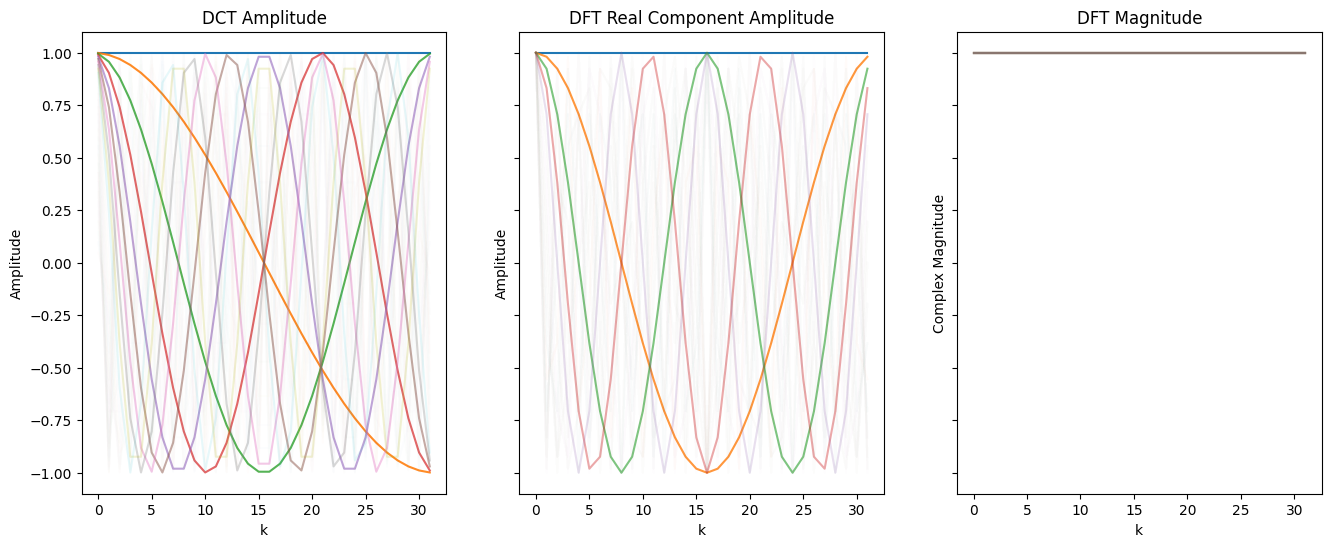

In [5]:
N: int = 32

fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16.0, 6.0)

plot_alpha: float = 1.0
for k in np.arange(N):
    cos_signal = dct_freq_component_signal(k, N)
    axes[0].plot(cos_signal, alpha=plot_alpha)
    plot_alpha = max(0.01, plot_alpha - 0.1)
axes[0].set_title(f"DCT Amplitude")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Amplitude")

plot_alpha: float = 1.0
for k in np.arange(N):
    cos_sin_signal = dft_freq_component_signal(k, N)
    axes[1].plot(cos_sin_signal.real, alpha=plot_alpha)
    plot_alpha = max(0.01, plot_alpha - 0.2)
axes[1].set_title(f"DFT Real Component Amplitude")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Amplitude")

plot_alpha: float = 1.0
for k in np.arange(N):
    cos_sin_signal = dft_freq_component_signal(k, N)
    axes[2].plot(np.abs(cos_sin_signal), alpha=plot_alpha)
    plot_alpha = max(0.01, plot_alpha - 0.1)
axes[2].set_title(f"DFT Magnitude")
axes[2].set_xlabel("k")
_ = axes[2].set_ylabel("Complex Magnitude")

Now let's visualize a transformed input signal from both the DCT and DFT.

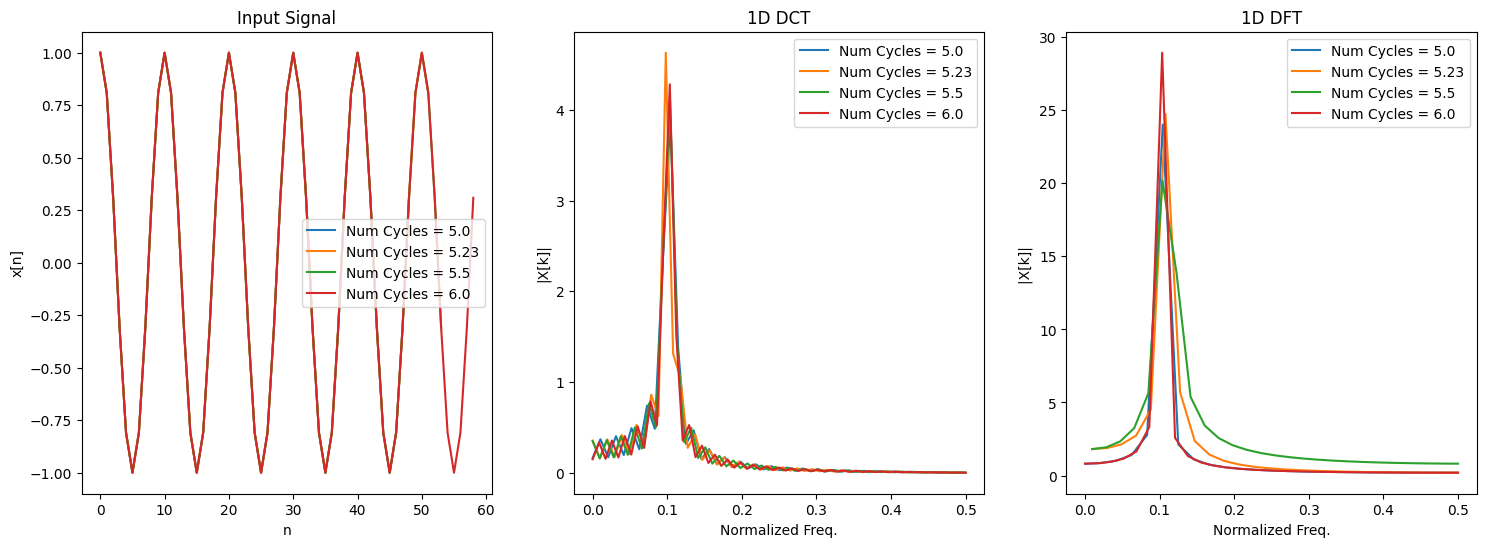

In [6]:
norm_freq: float = 0.1
num_cycles: list[float] = [5.0, 5.23, 5.5, 6.0]

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18, 6)

for num_cycle in num_cycles:
    num_samples = int(num_cycle // norm_freq)
    
    x = np.cos(2 * np.pi * norm_freq * np.arange(num_samples))

    axes[0].set_title("Input Signal")
    axes[0].set_xlabel("n")
    axes[0].set_ylabel("x[n]")
    axes[0].plot(x, label=f"Num Cycles = {num_cycle}")

    X = simple_1d_dct(x)
    freq_hz = np.linspace(0.0, 0.5, num_samples)
    axes[1].plot(freq_hz, np.abs(X), label=f"Num Cycles = {num_cycle}")
    axes[1].set_title("1D DCT")
    axes[1].set_xlabel("Normalized Freq.")
    axes[1].set_ylabel("|X[k]|")

    X = simple_1d_dft(x)
    X = np.roll(X, X.size // 2)
    freq_hz = np.linspace(-0.5, 0.5, num_samples)
    axes[2].plot(freq_hz[num_samples//2:], np.abs(X)[num_samples//2:], label=f"Num Cycles = {num_cycle}")
    axes[2].set_title("1D DFT")
    axes[2].set_xlabel("Normalized Freq.")
    axes[2].set_ylabel("|X[k]| ")
    
axes[0].legend()
axes[1].legend()
axes[2].legend()

_Note_ in the plots above how the DFT increases in the transformed "spectral width"  
and adds a slight normalized frequency offset as the `num_cycles` becomes  
non-integer multiples.

DCT exhibits spectral leakage as well, but less than the DFT for non-integer  
cycle input signals.

## 2D Transform Functions

Next we'll extend our 1D transform implementations for 2D, so we can apply them  
to 2D signal data types likes images.

### 2D Discrete Cosine Transform (DCT)

$$
X[u, v] = \alpha_{u} \alpha_{v} \sum_{x=0}^{N-1}\sum_{y=0}^{M-1}{x[x, y] \cdot cos(\frac{\pi}{N}(x + \frac{1}{2})u) \cdot cos(\frac{\pi}{M}(y + \frac{1}{2})v)}
$$

$$
\alpha_{u} = \begin{cases} 
  \sqrt{\frac{1}{N}} & \text{if } u = 0 \\
  \sqrt{\frac{2}{N}} & \text{if } u \neq 0 \\
\end{cases}
$$

$$
\alpha_{v} = \begin{cases} 
  \sqrt{\frac{1}{M}} & \text{if } v = 0 \\
  \sqrt{\frac{2}{M}} & \text{if } v \neq 0 \\
\end{cases}
$$

$$ u = 0, 1, 2, ..., N - 1$$

$$ v = 0, 1, 2, ..., M - 1 $$

### 2D Discrete Fourier Transform (DFT)

$$
X[u, v] = \sum_{x=0}^{N-1}\sum_{y=0}^{M-1}{x[x, y] \cdot \exp^{-j 2 \pi \frac{u}{N} x } \exp^{-j 2 \pi \frac{v}{M} y }}
$$

$$
= \sum_{x=0}^{N-1}\sum_{y=0}^{M-1}{x[x, y] \cdot \exp^{(-j 2 \pi \frac{u}{N} x) + (-j 2 \pi \frac{v}{M} y ) }}
$$

$$
= \sum_{x=0}^{N-1}\sum_{y=0}^{M-1}{x[x, y] \cdot \exp^{-j 2 \pi (\frac{u}{N} x + \frac{v}{M} y)} }
$$

$$ u = 0, 1, 2, ..., N - 1$$

$$ v = 0, 1, 2, ..., M - 1 $$

In [7]:
def dct_2d_freq_component_matrix(u: int, v: int, N: int, M: int) -> np.ndarray:
    x = np.arange(N)
    y = np.arange(M)
    component_mat = np.ones((N, M))
    component_mat *= np.cos((np.pi / N) * (x + 0.5) * u)[:, None]
    component_mat *= np.cos((np.pi / M) * (y + 0.5) * v)[None, :]
    return component_mat


def simple_2d_dct(x: np.ndarray) -> np.ndarray:
    N, M = x.shape
    X = np.zeros_like(x)
    alpha_u: float
    alpha_v: float
    for u in np.arange(N):
        if u == 0: alpha_u = np.sqrt(1.0 / N)
        else: alpha_u = np.sqrt(2.0 / N)
        for v in np.arange(M):
            if v == 0: alpha_v = np.sqrt(1.0 / M)
            else: alpha_v = np.sqrt(2.0 / M)
            
            X[u, v] = alpha_u * alpha_v * np.sum(
                x * dct_2d_freq_component_matrix(u, v, N, M)
            )
    return X

In [8]:
def dft_2d_freq_component_matrix(u: int, v: int, N: int, M: int) -> np.ndarray:
    x = np.arange(N)
    y = np.arange(M)
    component_mat = np.ones((N, M), dtype=np.complex128)
    component_mat *= np.exp(-1j * 2 * np.pi * u * x / N)[:, None]
    component_mat *= np.exp(-1j * 2 * np.pi * v * y / M)[None, :]
    return component_mat


def simple_2d_dft(x: np.ndarray) -> np.ndarray:
    N, M = x.shape
    X = np.zeros_like(x)
    X = X.astype(np.complex128)
    x_comp = x.astype(np.complex128)
    for u in np.arange(N):
        for v in np.arange(M):
            X[u, v] = np.sum(x_comp * dft_2d_freq_component_matrix(u, v, N, M))
    return X

Now we can visualize the 2D basis function matrices that will be applied  
for each one of the transforms.

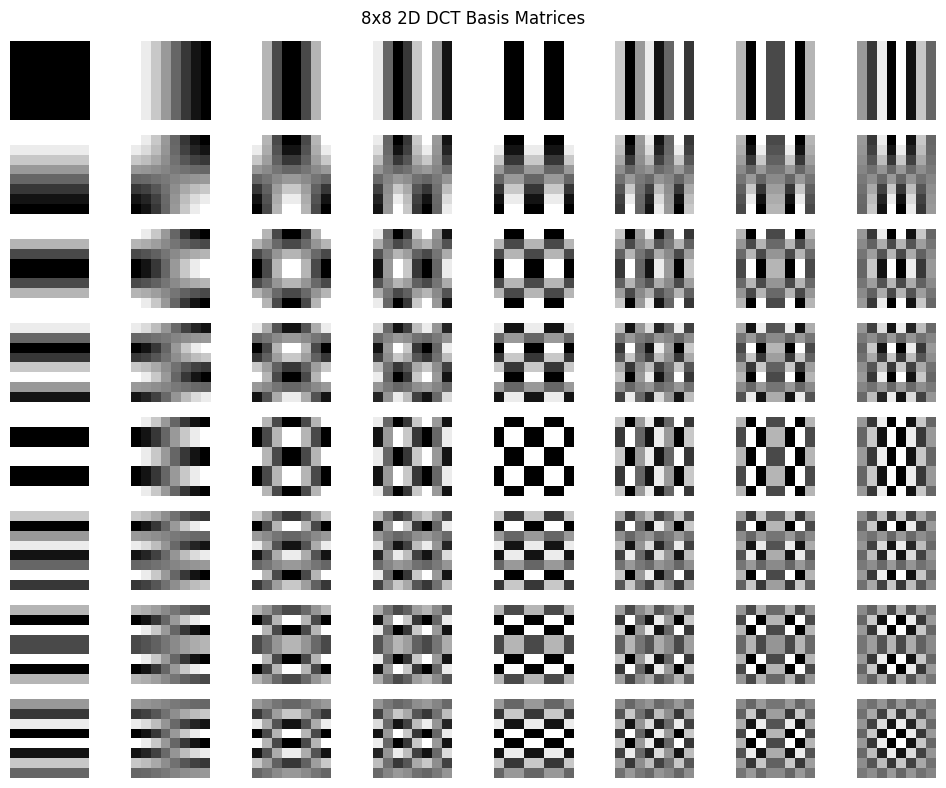

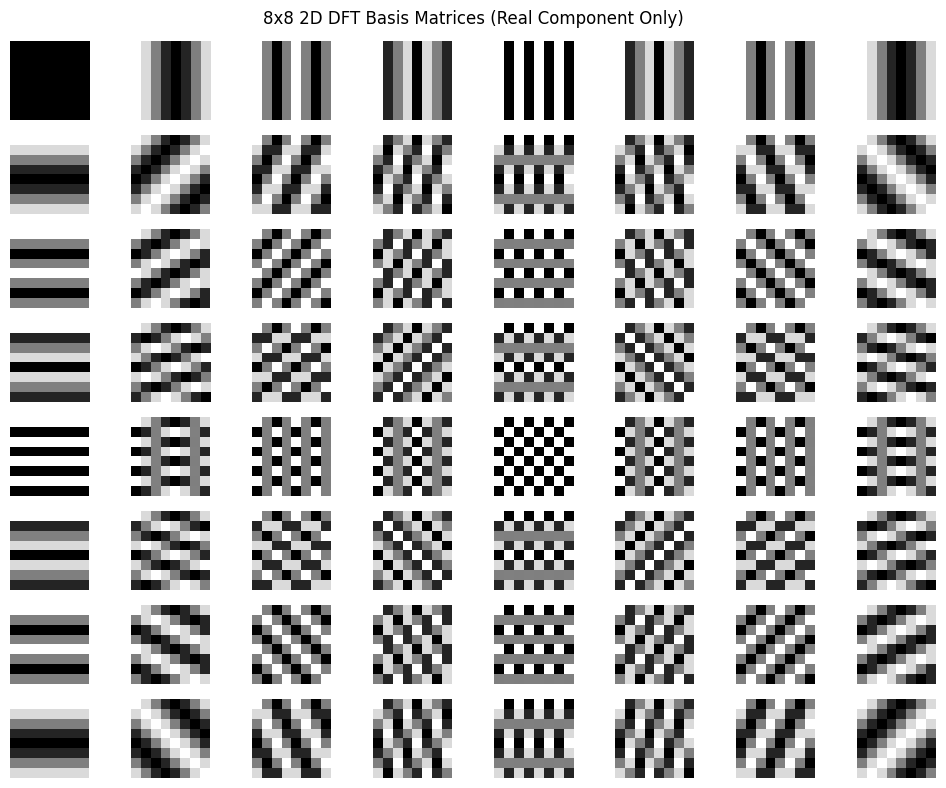

In [9]:
N: int = 8
M: int = 8

# Iterate over NxM matrices for 2D DCT.
fig, axes = plt.subplots(N, M)
fig.set_size_inches(10.0, 8.0)
fig.suptitle(f"{N}x{M} 2D DCT Basis Matrices")
for u in np.arange(N):
    for v in np.arange(M):
        mat = dct_2d_freq_component_matrix(u, v, N, M)
        
        axes[u][v].imshow(mat, cmap="grey")
        axes[u][v].set_axis_off()
fig.tight_layout()

# Iterate over NxM matrices for 2D DFT.
fig, axes = plt.subplots(N, M)
fig.set_size_inches(10.0, 8.0)
fig.suptitle(f"{N}x{M} 2D DFT Basis Matrices (Real Component Only)")
for u in np.arange(N):
    for v in np.arange(M):
        mat = dft_2d_freq_component_matrix(u, v, N, M)
        
        axes[u][v].imshow(mat.real, cmap="grey")
        axes[u][v].set_axis_off()
fig.tight_layout()

Lastly, let's implement the 2D inverses of both the `DCT` and `DFT`, so we can  
test each for compression later. We can additionally confirm that each inverse  
transformation is correct up to some precision point value.

### 2D Inverse Discrete Cosine Transform (IDCT)

$$
x[x, y] =  \sum_{u=0}^{N-1}\sum_{v=0}^{M-1}{\alpha_{u} \alpha_{v} X[u, v] \cdot cos(\frac{\pi}{N}(x + \frac{1}{2})u) \cdot cos(\frac{\pi}{M}(y + \frac{1}{2})v)}
$$

$$
\alpha_{u} = \begin{cases} 
  \sqrt{\frac{1}{N}} & \text{if } u = 0 \\
  \sqrt{\frac{2}{N}} & \text{if } u \neq 0 \\
\end{cases}
$$

$$
\alpha_{v} = \begin{cases} 
  \sqrt{\frac{1}{M}} & \text{if } v = 0 \\
  \sqrt{\frac{2}{M}} & \text{if } v \neq 0 \\
\end{cases}
$$

$$ x = 0, 1, 2, ..., N - 1$$

$$ y = 0, 1, 2, ..., M - 1 $$

### 2D Inverse Discrete Fourier Transform (IDFT)

$$
x[x, y] = \frac{1}{NM} \sum_{u=0}^{N-1}\sum_{v=0}^{M-1}{X[u, v] \cdot \exp^{j 2 \pi (\frac{u}{N} x + \frac{v}{M} y)} }
$$

$$ x = 0, 1, 2, ..., N - 1$$

$$ y = 0, 1, 2, ..., M - 1 $$

In [10]:
def idct_2d_freq_component_matrix(x: int, y: int, N: int, M: int) -> np.ndarray:
    u = np.arange(N)
    v = np.arange(M)
    component_mat = np.ones((N, M))
    component_mat *= np.cos((np.pi / N) * (x + 0.5) * u)[:, None]
    component_mat *= np.cos((np.pi / M) * (y + 0.5) * v)[None, :]
    
    alpha_u = np.ones_like(component_mat)
    alpha_u[0, :] = np.sqrt(1.0 / N)
    alpha_u[1:, :] = np.sqrt(2.0 / N)
    
    alpha_v = np.ones_like(component_mat)
    alpha_v[:, 0] = np.sqrt(1.0 / M)
    alpha_v[:, 1:] = np.sqrt(2.0 / M)
    
    return alpha_u * alpha_v * component_mat


def simple_2d_idct(X: np.ndarray) -> np.ndarray:
    N, M = X.shape
    x = np.zeros_like(X)
    for xi in np.arange(N):
        for yi in np.arange(M):
            x[xi, yi] = np.sum(X * idct_2d_freq_component_matrix(xi, yi, N, M))
    return x

In [11]:
def idft_2d_freq_component_matrix(x: int, y: int, N: int, M: int) -> np.ndarray:
    u = np.arange(N)
    v = np.arange(M)
    component_mat = np.ones((N, M), dtype=np.complex128)
    component_mat *= np.exp(1j * 2 * np.pi * u * x / N)[:, None]
    component_mat *= np.exp(1j * 2 * np.pi * v * y / M)[None, :]
    return component_mat


def simple_2d_idft(X: np.ndarray) -> np.ndarray:
    N, M = X.shape
    x = np.zeros_like(X)
    x = X.astype(np.complex128)
    for xi in np.arange(N):
        for yi in np.arange(M):
            x[xi, yi] = (1.0 / (N * M)) * np.sum(
                X * idft_2d_freq_component_matrix(xi, yi, N, M)
            )

    return x

In [12]:
N: int = 5
M: int = 6
sample_mat = np.arange(N, dtype=np.float64)
sample_mat = np.tile(sample_mat, (M, 1))
sample_mat

array([[0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.]])

Is the inverse `2D_DCT` correct?

In [13]:
mat_inv = simple_2d_idct(simple_2d_dct(sample_mat))
np.round(mat_inv)

array([[-0.,  1.,  2.,  3.,  4.],
       [-0.,  1.,  2.,  3.,  4.],
       [-0.,  1.,  2.,  3.,  4.],
       [-0.,  1.,  2.,  3.,  4.],
       [-0.,  1.,  2.,  3.,  4.],
       [-0.,  1.,  2.,  3.,  4.]])

Is the inverse `2D_DFT` correct?

In [14]:
mat_inv = simple_2d_idft(simple_2d_dft(sample_mat))
np.round(mat_inv.real)

array([[0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.]])

## 2D Transform Compression

Great! Now let's test reconstructing sample input matrices when dropping out the  
lowest amplitude coefficients from each transform.

In [15]:
from PIL import Image

In [16]:
img_shape: tuple[int, int] = (256, 256)
img_path: str = 'data/moon_grayscale.jpg'

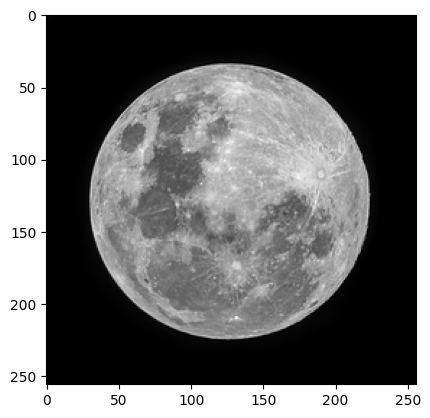

In [17]:
img = Image.open(img_path)

# We'll convert the JPG image to grayscale and resize the image so it's faster 
# to compute each of the transforms across the matrix.
img = img.convert("L")
img = img.resize(img_shape, Image.Resampling.LANCZOS)

# Next, we'll cast the Image object to a ndarray so we can process the 2D 
# matrix.
img_arr = np.array(img)
img_arr = img_arr.astype(np.float64)
plt.imshow(img_arr, cmap="grey")

In [18]:
print(f"Image Min Value: {img_arr.min()}")
print(f"Image Max Value: {img_arr.max()}")
print(f"Image Shape: {img_arr.shape}")

Image Min Value: 0.0
Image Max Value: 240.0
Image Shape: (256, 256)


Now we can define and test a simple dropout compression function and visualize  
the performance of each transform when dropping out the same number of  
coefficients.

In [19]:
from typing import Callable

In [20]:
transform_type = Callable[[np.ndarray], np.ndarray]

In [21]:
def compression(
    img: np.ndarray, 
    compression_ratio: float,
    transform: transform_type,
    inverse_transform: transform_type,
) -> np.ndarray:
    img_transform = transform(img)
    
    threshold = np.percentile(np.abs(img_transform), compression_ratio * 100.0)
    img_transform_compressed = np.copy(img_transform)
    img_transform_compressed[np.abs(img_transform) < threshold] = 0.0
    
    return inverse_transform(img_transform_compressed)

In [22]:
compression_ratio: float = 0.90

img_arr_dct_compress = compression(
    img_arr, 
    compression_ratio,
    simple_2d_dct,
    simple_2d_idct
)

img_arr_dft_compress = compression(
    img_arr, 
    compression_ratio,
    simple_2d_dft,
    simple_2d_idft
)

Text(0.5, 1.0, 'DFT 0.9 Compressed Image')

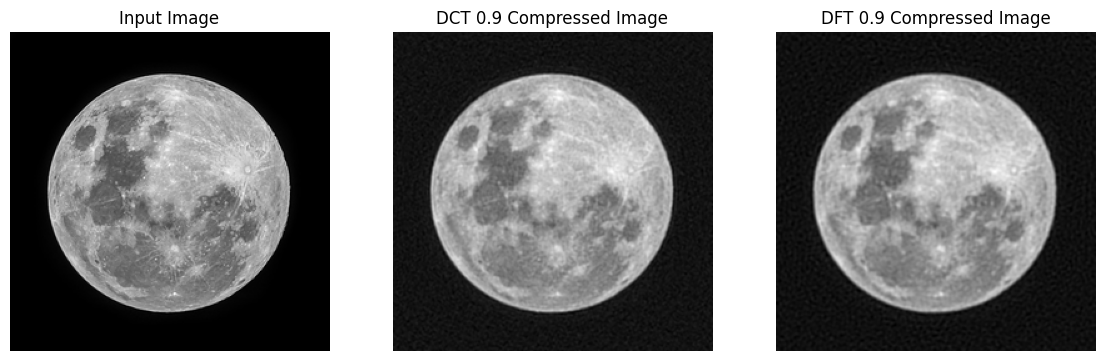

In [23]:
# Plot the input and compressed image arrays side by side.
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(14.0, 10.0)
axes[0].imshow(img_arr, cmap="grey")
axes[0].set_axis_off()
axes[0].set_title("Input Image")

axes[1].imshow(img_arr_dct_compress, cmap="grey")
axes[1].set_axis_off()
axes[1].set_title(f"DCT {compression_ratio} Compressed Image")

axes[2].imshow(img_arr_dft_compress.real, cmap="grey")
axes[2].set_axis_off()
axes[2].set_title(f"DFT {compression_ratio} Compressed Image")

### 2D Segmented Compression

[JPEG](https://en.wikipedia.org/wiki/JPEG) is known to use a segmented 8x8 DCT, quantization tables, and encoding schemes  
for image compression. One of the core differences from what was done above, is that  
both the DCT and DFT were computed across the entirety of the original image's  
dimensionality. 

We can re-attempt each transformation compression approach by first segmenting  
the input image into blocks of smaller localized pixel regions.

In [24]:
segment_size:int = 8
num_segment_rows = img_shape[0] // segment_size
num_segment_cols = img_shape[1] // segment_size

Let's first visualize how our `img` will be segmented in non-overlapping regions.

Text(0.5, 1.0, '8x8 Segmented Image')

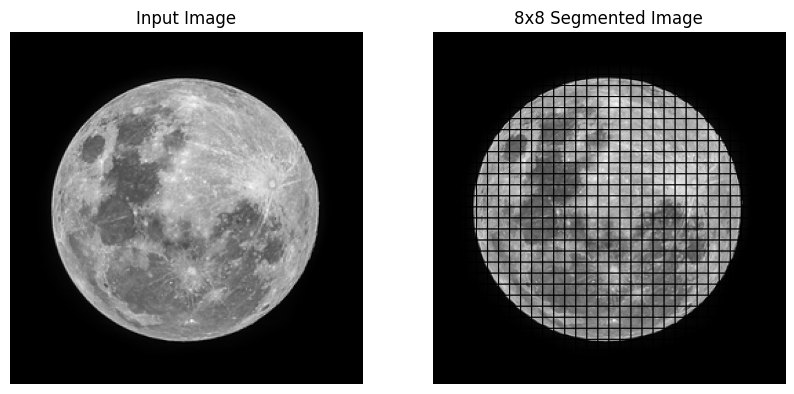

In [25]:
img_segment_shape: tuple[int, int] = (
    img_shape[0] + num_segment_rows, img_shape[1] + num_segment_cols
)
img_arr_segment = np.zeros(img_segment_shape)
for ri in np.arange(num_segment_rows):
    ri_start = ri * segment_size
    ri_stop = ri_start + segment_size
    for ci in np.arange(num_segment_cols):
        ci_start = ci * segment_size
        ci_stop = ci_start + segment_size
        
        img_arr_segment[
            (ri_start + ri):(ri_stop + ri), (ci_start + ci):(ci_stop + ci)
        ] = img_arr[ri_start:ri_stop, ci_start:ci_stop]
        
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10.0, 6.0)
axes[0].imshow(img_arr, cmap="grey")
axes[0].set_axis_off()
axes[0].set_title("Input Image")

axes[1].imshow(img_arr_segment, cmap="grey")
axes[1].set_axis_off()
axes[1].set_title(f"{segment_size}x{segment_size} Segmented Image")

Now let's try applying _DCT_ and _DFT_ compression across each of the segmented  
images.

In [26]:
def segmented_compression(
    img: np.ndarray, 
    segment_size: int,
    compression_ratio: float,
    transform: transform_type,
    inverse_transform: transform_type,
) -> np.ndarray:
    compressed_img = np.zeros_like(img)
    num_rows, num_cols = img.shape
    num_segment_rows = num_rows // segment_size
    num_segment_cols = num_cols // segment_size
    
    for ri in np.arange(num_segment_rows):
        ri_start = ri * segment_size
        ri_stop = ri_start + segment_size
        for ci in np.arange(num_segment_cols):
            ci_start = ci * segment_size
            ci_stop = ci_start + segment_size
            
            img_segment = img_arr[ri_start:ri_stop, ci_start:ci_stop]
            img_segment_compressed = compression(
                img_segment, compression_ratio, transform, inverse_transform
            ).real
            compressed_img[
                ri_start:ri_stop, ci_start:ci_stop
            ] = img_segment_compressed
    
    return compressed_img

In [27]:
compression_ratio: float = 0.90

img_arr_dct_compress = segmented_compression(
    img_arr, 
    segment_size,
    compression_ratio,
    simple_2d_dct,
    simple_2d_idct
)

img_arr_dft_compress = segmented_compression(
    img_arr, 
    segment_size,
    compression_ratio,
    simple_2d_dft,
    simple_2d_idft
)

Text(0.5, 1.0, '8x8 Segmented DFT 0.9 Compressed Image')

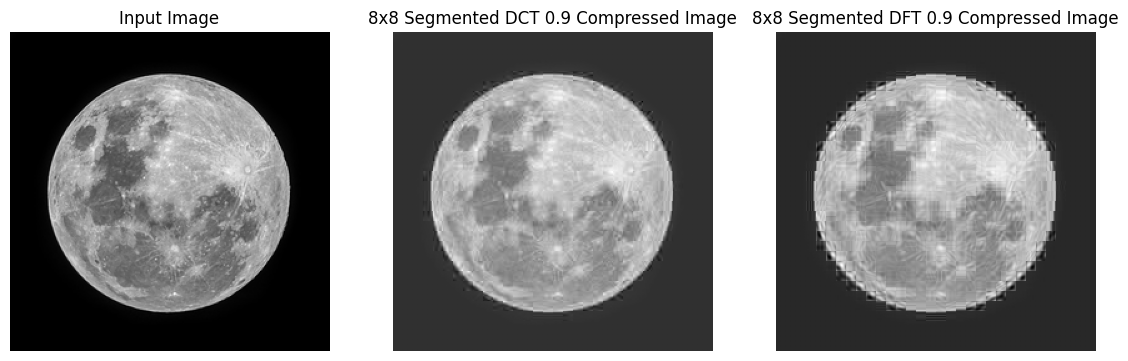

In [28]:
# Plot the input and compressed image arrays side by side.
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(14.0, 10.0)
axes[0].imshow(img_arr, cmap="grey")
axes[0].set_axis_off()
axes[0].set_title("Input Image")

axes[1].imshow(img_arr_dct_compress, cmap="grey")
axes[1].set_axis_off()
axes[1].set_title(f"{segment_size}x{segment_size} Segmented DCT {compression_ratio} Compressed Image")

axes[2].imshow(img_arr_dft_compress.real, cmap="grey")
axes[2].set_axis_off()
axes[2].set_title(f"{segment_size}x{segment_size} Segmented DFT {compression_ratio} Compressed Image")

_Note_, this is still not quite how **JPEG** compression is done. Predefined  
quantization tables are used in replace of argtsorted and dropped coefficients  
for compression.

DCT transformed coefficients are quantized using predefined quantization tables  
in an $8x8$ grid, rounded to the nearest integer, then inverted back to the  
original image space.


$$
DCT := X[u, v] = \alpha_{u} \alpha_{v} \sum_{x=0}^{N-1}\sum_{y=0}^{M-1}{x[x, y] \cdot cos(\frac{\pi}{N}(x + \frac{1}{2})u) \cdot cos(\frac{\pi}{M}(y + \frac{1}{2})v)}
$$

$$
X'_{quantized}[u, v] = round(\frac{X[u, v]}{\lambda \Delta[u, v]})
$$

$$\Delta \text{ - Predefined quantization table}$$

$$\lambda \text{ - Scalar to control quantization applied}$$

Let's test a sample quantization table for grayscale images and visualize the  
quantization effects.

In [29]:
delta_q = np.array(
    [
        [16.0, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],  
    ]
    
)

Note how `delta_q` generally increases in coefficients value as frequency in  
both dimensions increases. It's predefined to more heavily weight the importance  
of lower frequency content than higher frequency content for $8x8$ segmented  
images.

In [30]:
def quantized_segmented_compression(
    img: np.ndarray, 
    delta_q: np.ndarray,    
    transform: transform_type,
    inverse_transform: transform_type,
) -> np.ndarray:
    compressed_img = np.zeros_like(img)
    num_rows, num_cols = img.shape
    
    # We're assuming that the delta_q quantization matrix is square across rows
    # and columns.
    segment_size = delta_q.shape[0] 
    num_segment_rows = num_rows // segment_size
    num_segment_cols = num_cols // segment_size
    
    for ri in np.arange(num_segment_rows):
        ri_start = ri * segment_size
        ri_stop = ri_start + segment_size
        for ci in np.arange(num_segment_cols):
            ci_start = ci * segment_size
            ci_stop = ci_start + segment_size
            
            img_segment = img_arr[ri_start:ri_stop, ci_start:ci_stop]

            img_segment_transform = transform(img_segment)
            img_segment_transform_quant = np.round(
                img_segment_transform / delta_q
            )
            img_segment_quant = inverse_transform(img_segment_transform_quant)
            compressed_img[
                ri_start:ri_stop, ci_start:ci_stop
            ] = img_segment_quant
            
    return compressed_img

In [31]:
img_arr_dct_quant = quantized_segmented_compression(
    img_arr, 
    delta_q,
    simple_2d_dct,
    simple_2d_idct
)

Text(0.5, 1.0, '8x8 Segmented Quantized DCT Image')

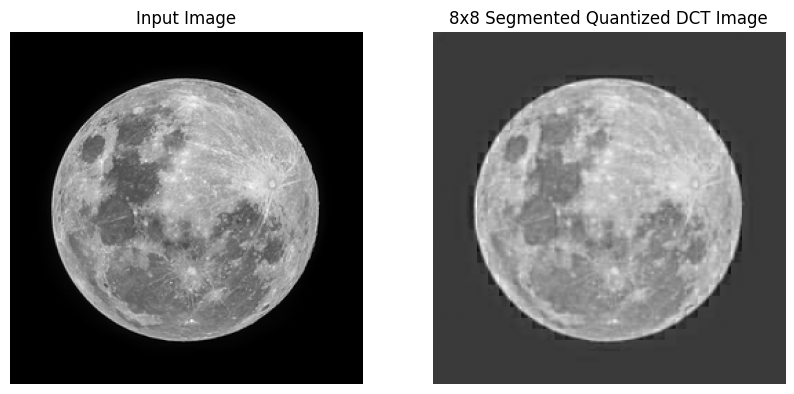

In [32]:
# Plot the input and compressed image arrays side by side.
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10.0, 6.0)
axes[0].imshow(img_arr, cmap="grey")
axes[0].set_axis_off()
axes[0].set_title("Input Image")

axes[1].imshow(img_arr_dct_quant, cmap="grey")
axes[1].set_axis_off()
axes[1].set_title(f"{segment_size}x{segment_size} Segmented Quantized DCT Image")